# Mincer earnings equation estimation

Our task is to construct model that explains wage income of bank's clients.

The available data consists of 42 groups of summary statistics (7 summary statistics in one group) about different aspects of cash spending/cash obtaining, that the clients undergoes during the last 6 months (also one variable equals to age).

The main purpose of this notebook is to carry out break-down analysis to understand the model's prediction for a single observation.

To reduce number of features, instead of using all the summary statistics, we will focus on one, that gives the best results. It will be picked by cross-validation on the train dataset.

The model used to perform experiments is XGBoost.

### 3
At first we will decompose two random observations.

#### Observation #1 (break-down plots for additive attribution and interactions)

<img src="../reports/figures/random_sample_num=0.png" alt="drawing" width="700"/>

From the plot we can see that the client's income is well above average income. X284 (total amount of client's deposits in the last 6 months) have the most contribution to prediction, next is X193 (money spent on air transport). We can predict that people with higher earnings, would use airplane to save time, which the analysis approves.

Paired-variable positive contribution of X151:X1 (dining at restaurants:age) is positive, that also goes well with intuition, because low-class people won't eat at restaurants and the older someone becomes the more wealth he has accumulated.

Interesting thing is that X60 and X88 (spending at the supermarket or in smaller shops) value of 0 is a positive contribution, which suggests that the less someone spends there, the more he should earn.

#### Observation #2 (break-down plots for additive attribution and interactions)

<img src="../reports/figures/random_sample_num=1.png" alt="drawing" width="700"/>

The big contribution of X25 (total spending of the client) is quite counter-intuitive, taking into the consideration that the value of the feature is so small.

X284 (total amount of client's deposits in the last 6 months), X291 (total amount of the client's salary receipts), X221 (buying clothes), X151 (dining at restaurants), X11 (pharmacy expenses), X1 (age) are negative contribution, and by looking at their values they should be negative.

X60 (spending at the supermarket) although 0 in value is surprisingly a negative contribution, in contrast to the previous sample (the reason is probably lack of order-invariant property in break-down method).

### 4
The next thing to do is to find two observations in the data set, such that they have different variables of the highest importance.

#### Observation #1 (break-down plots for additive attribution and interactions)

<img src="../reports/figures/different_highest=0.png" alt="drawing" width="700"/>


#### Observation #2 (break-down plots for additive attribution and interactions)

<img src="../reports/figures/different_highest=1.png" alt="drawing" width="700"/>


### 5
Now we will find two observations in the dataset that have different signs on contribution of X60 (spending at the supermarket)

#### Observation #1 (break-down plots for additive attribution and interactions)

<img src="../reports/figures/different_sign=0.png" alt="drawing" width="700"/>

#### Observation #2 (break-down plots for additive attribution and interactions)

<img src="../reports/figures/different_sign=1.png" alt="drawing" width="700"/>

By looking at the current and previous experiments, we can say that the models seems to establish a rule that spending any money at the supermarket negatively influency the income of a client.

### 6
The last thing to do is to check how a different model would assign attributions. \
The 'different model' will be Random Forest.

#### Observation #1 - XGBoost (break-down plots for additive attribution and interactions)

<img src="../reports/figures/different_across_models=xgb.png" alt="drawing" width="700"/>

#### Observation #2 - Random Forest (break-down plots for additive attribution and interactions)

<img src="../reports/figures/different_across_models=rf.png" alt="drawing" width="700"/>

The contributions start to differ almost immediately. In Random Forest a positive contribution from X102 (cafes) is at the second place, where in XGBoost it is much smaller (and negative).

Yet there are some common points like X284 (total amount of client's deposits in the last 6 months) or X81 (fastfoods).

## Summary
The model meets our expectations. Things like age, eating at restaurants, air travel, going to cafés, contributes positively to the expected income of a client, and things like going to the supermarkets/small shops, being relatively young, train travel, contribute negatively.

 Although the thing that need further investigation is the role of variable X25 (total spending).

## Appendix

In [1]:
import random

import dalex as dx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn import model_selection, ensemble

sns.set_theme()

C:\Users\alan\anaconda3\envs\xai\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
seed = 357

random.seed(seed)
np.random.seed(seed)

In [3]:
data = pd.read_csv('../data/raw/temat_2_dane.csv')
data_cols_description = pd.read_excel('../data/raw/temat_2_opis_zmiennych.xlsx')

In [4]:
data.head(10)

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X286,X287,X288,X289,X290,X291,X292,X293,X294,X295
0,3563.00,27,0.0,0.0,0.0,0.0,0,0,0,23.4,...,27,48,95,6883.0,21767.1,43137.0,7255.7,2,6,12
1,8522.00,27,0.0,0.0,0.0,0.0,0,0,0,126.8,...,2,8,11,0.0,0.0,0.0,0.0,0,0,0
2,15000.00,33,0.0,0.0,0.0,0.0,0,0,0,88.0,...,7,18,58,15359.4,46078.3,92210.3,15359.4,2,6,13
3,6883.43,34,0.0,0.0,0.0,0.0,0,0,0,280.9,...,5,28,46,7375.3,21832.7,38992.3,7277.6,1,3,6
4,5132.69,39,0.0,0.0,0.0,0.0,0,0,0,0.0,...,14,38,78,4262.5,14908.1,29670.8,4969.4,2,7,13
5,6209.81,38,0.0,0.0,0.0,0.0,0,0,0,0.0,...,4,14,28,0.0,0.0,0.0,0.0,0,0,0
6,8664.00,49,0.0,0.0,0.0,0.0,0,0,0,17.0,...,7,20,31,5039.1,15174.6,15174.6,5058.2,1,3,3
7,2900.00,29,0.0,0.0,0.0,0.0,0,0,0,39.8,...,1,9,17,0.0,0.0,0.0,0.0,0,0,0
8,4163.00,31,900.0,2700.0,5400.0,900.0,1,3,6,0.0,...,5,15,21,4171.5,12479.5,24300.6,4159.8,1,3,6
9,6148.00,26,0.0,0.0,0.0,0.0,0,0,0,143.0,...,1,4,8,0.0,0.0,0.0,0.0,0,0,0


In [5]:
data_cols_description.head(10)

,NAZWA,OPIS
0,Y,"zmienna objaśniana, dochód netto klienta w mom..."
1,X1,wiek klienta
2,X2,Sumaryczna kwota wydatków klienta związanych z...
3,X3,Sumaryczna kwota wydatków klienta związanych z...
4,X4,Sumaryczna kwota wydatków klienta związanych z...
5,X5,Średnia kwota wydatków klienta związanych z pł...
6,X6,Sumaryczna liczba wydatków klienta związanych ...
7,X7,Sumaryczna liczba wydatków klienta związanych ...
8,X8,Sumaryczna liczba wydatków klienta związanych ...
9,X9,Sumaryczna kwota wydatków klienta w aptekach w...


In [6]:
data_train, data_test = model_selection.train_test_split(data, test_size=0.2, shuffle=True)

In [7]:
X_train, y_train = data_train.drop('Y', axis=1), data_train['Y']

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

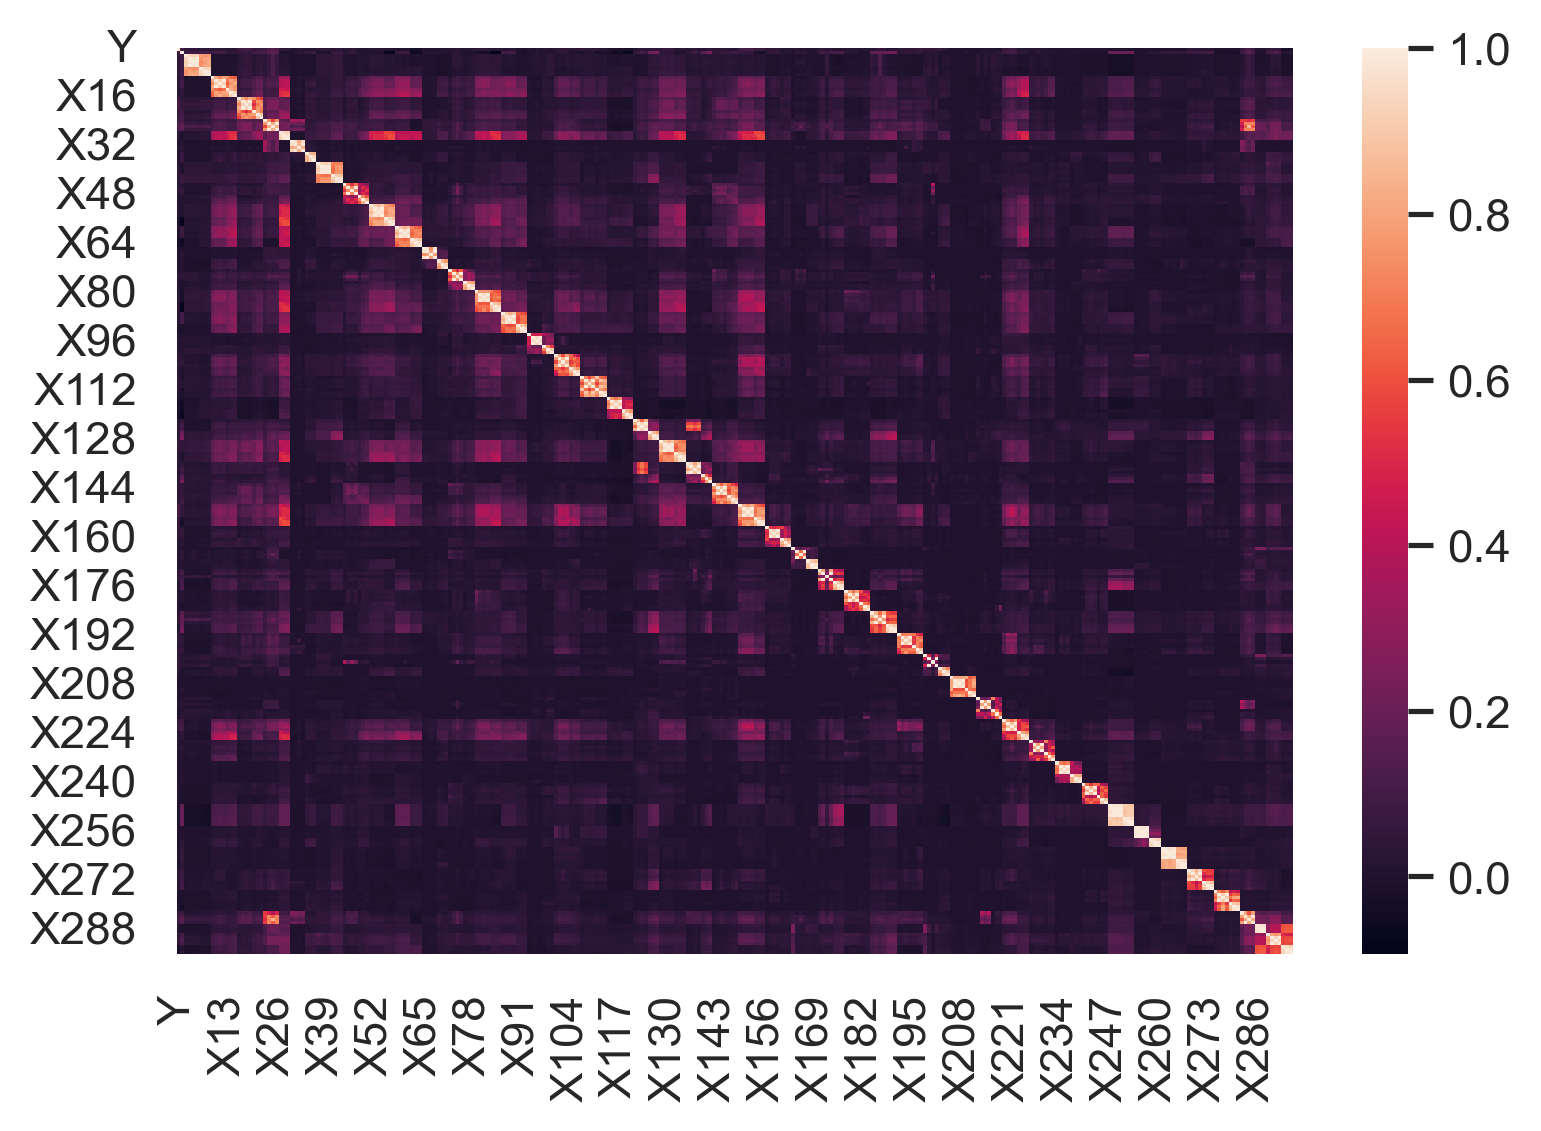

In [8]:
plt.figure(dpi=300)
sns.heatmap(data_train.corr())
plt.savefig('../reports/figures/vars_corr.png')

In [9]:
scores = {}
for i in range(2, 8 + 1):
    picked_vars = ['X1'] + [f'X{j}' for j in range(i, 295 + 1, 7)]

    model = ensemble.RandomForestRegressor()
    cv = model_selection.GridSearchCV(ensemble.RandomForestRegressor(), param_grid={}, cv=4, scoring='neg_mean_absolute_error', n_jobs=4)
    cv.fit(X_train[picked_vars], y_train)
    scores[f'X{i}'] = cv.best_score_

In [10]:
scores

{'X2': -4815.891386571607,
 'X3': -4690.429401960471,
 'X4': -4635.164264919846,
 'X5': -4701.176052691826,
 'X6': -5688.276405681493,
 'X7': -5844.218109420357,
 'X8': -5493.564679451433}

In [11]:
picked_vars = ['X1'] + [f'X{j}' for j in range(4, 295 + 1, 7)]

In [12]:
X_train = X_train[picked_vars]

In [13]:
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)

C:\Users\alan\anaconda3\envs\xai\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [14]:
explainer_model_xgb = dx.Explainer(model_xgb, X_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 8000 rows 43 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 8000 values
  -> model_class       : xgboost.sklearn.XGBRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x000001F6643A5550> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.02e+03, mean = 9.53e+03, max = 2.04e+06
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.54e+04, mean = 3.63, max = 7.28e+04
  -> model_info        : package xgboost

A new explainer has been created!


In [15]:
random_samples = data_test.sample(2, random_state=256)

In [16]:
for i in range(len(random_samples)):
    X = random_samples.drop('Y', axis=1)[picked_vars].iloc[[i]]
    y = random_samples['Y'].iloc[i]

    bd = explainer_model_xgb.predict_parts(X, type='break_down', label=y)
    bd_interactions = explainer_model_xgb.predict_parts(X, type='break_down_interactions', label=y)
    plot = bd.plot(bd_interactions, max_vars=50, show=False)
    plot.write_image(file=f'../reports/figures/random_sample_num={i}.png', engine='orca', scale=4.0)

In [17]:
idx_diff_highest_a = 0
observation_a = data_test.iloc[idx_diff_highest_a][picked_vars]
observation_a_label = data_test.iloc[idx_diff_highest_a]['Y']
bd_a = explainer_model_xgb.predict_parts(observation_a, type='break_down', label=observation_a_label)
bd_interactions_a = explainer_model_xgb.predict_parts(observation_a, type='break_down_interactions', label=observation_a_label)
two_vars_of_highest_contribution_a = bd_interactions_a.result[['variable_name', 'contribution']][1:].head(2)

for idx_diff_highest_b in range(idx_diff_highest_a + 1, len(data_test)):
    observation_b = data_test.iloc[idx_diff_highest_b][picked_vars]
    observation_b_label = data_test.iloc[idx_diff_highest_b]['Y']
    bd_b = explainer_model_xgb.predict_parts(observation_b, type='break_down', label=observation_b_label)
    bd_interactions_b = explainer_model_xgb.predict_parts(observation_b, type='break_down_interactions', label=observation_b_label)
    two_vars_of_highest_contribution_b = bd_interactions_b.result[['variable_name', 'contribution']][1:].head(2)

    if len(set(two_vars_of_highest_contribution_a['variable_name']) & set(two_vars_of_highest_contribution_b['variable_name'])) == 0:
        break

In [18]:
for i, (bd, bd_interactions) in enumerate([(bd_a, bd_interactions_a),
                            (bd_b, bd_interactions_b)]):
    plot = bd.plot(bd_interactions, max_vars=50, show=False)
    plot.write_image(file=f'../reports/figures/different_highest={i}.png', engine='orca', scale=4.0)

In [19]:
var = 'X60'
idx_diff_sign_a = 625

observation_a = data_test.iloc[idx_diff_sign_a][picked_vars]
observation_a_label = data_test.iloc[idx_diff_sign_a]['Y']
bd_a = explainer_model_xgb.predict_parts(observation_a, type='break_down', label=observation_a_label)
bd_interactions_a = explainer_model_xgb.predict_parts(observation_a, type='break_down_interactions', label=observation_a_label)
sign_a = bd_a.result[bd_a.result['variable_name'] == var]['sign'].values[0]

for idx_diff_sign_b in range(idx_diff_sign_a + 1, len(data_test)):
    observation_b = data_test.iloc[idx_diff_sign_b][picked_vars]
    observation_b_label = data_test.iloc[idx_diff_sign_b]['Y']
    bd_b = explainer_model_xgb.predict_parts(observation_b, type='break_down', label=observation_b_label)
    bd_interactions_b = explainer_model_xgb.predict_parts(observation_b, type='break_down_interactions', label=observation_b_label)
    sign_b = bd_b.result[bd_b.result['variable_name'] == var]['sign'].values[0]

    if sign_a * sign_b < 0:
        break

In [20]:
for i, (bd, bd_interactions) in enumerate([(bd_a, bd_interactions_a),
                            (bd_b, bd_interactions_b)]):
    plot = bd.plot(bd_interactions, max_vars=50, show=False)
    plot.write_image(file=f'../reports/figures/different_sign={i}.png', engine='orca', scale=4.0)

In [21]:
model_rf = ensemble.RandomForestRegressor()
model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [22]:
explainer_model_rf = dx.Explainer(model_rf, X_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 8000 rows 43 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 8000 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x000001F6643A5550> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.29e+03, mean = 9.56e+03, max = 1.34e+06
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)


C:\Users\alan\anaconda3\envs\xai\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



  -> residuals         : min = -4.53e+05, mean = -28.6, max = 7.2e+05
  -> model_info        : package sklearn

A new explainer has been created!


In [23]:
idx = 300
for idx in range(idx + 1, len(data_test)):
    obs = data_test.iloc[idx][picked_vars]
    obs_label = data_test.iloc[idx]['Y']

    bd_xgb = explainer_model_xgb.predict_parts(obs, type='break_down', label=obs_label)
    bd_rf = explainer_model_rf.predict_parts(obs, type='break_down', label=obs_label)

    if (bd_xgb.result['variable_name'] != bd_rf.result['variable_name']).any():
        break

In [24]:
for model, bd in [('xgb', bd_xgb), ('rf', bd_rf)]:
    plot = bd.plot(max_vars=50, show=False)
    plot.write_image(file=f'../reports/figures/different_across_models={model}.png', engine='orca', scale=4.0)